In [1]:
from mpi4py import MPI
import coqui

import numpy as np
from scipy.constants import physical_constants
HARTREE_EV = physical_constants['Hartree energy in eV'][0]

import matplotlib.pyplot as plt

# Create CoQui MPI handler and set logging verbosity in the beginning 
coqui_mpi = coqui.MpiHandler()
coqui.set_verbosity(coqui_mpi, output_level=1)

--------------------------------------------------------------------------
Ignoring value for oob_tcp_if_exclude on ccqlin065 (10.250.112.0/20: Did not find interface matching this subnet).
(You can safely ignore this message.)
--------------------------------------------------------------------------


# cRPA Screened Interactions with CoQuí

In the previous GW tutorial, we have learned how to perform a GW electronic-structure calculation in CoQuí using a compressed Coulomb Hamiltonian and how to post-process the results with maximally localized Wannier functions (MLWFs). Beyond post-processing, **MLWFs also play a central role in CoQuí’s embedding and downfolding functionality**, providing the **bridge** between a full *ab initio* calculation and a reduced low-energy description.  

In this notebook, we explore one such application: using the **constrained random phase approximation (cRPA)** to computes the *frequency-dependent effective Coulomb interactions* $U(\omega)$ for the V $t_{2g}$ states in SrVO$_3$ (highlighted in red in Figure 1). By separating screening processes exclusively *within* the target subspace (V $t_{2g}$) from those *outside* it, cRPA delivers the *residual* screening needed to construct an effective low-energy Hamiltonian. This procedure is central to embedding approaches such as DMFT or EDMFT, where the Hubbard $U(\omega)$ serves as a key input.  

<figure style="text-align: center;">
  <img src="../images/svo_crpa_cartoon.png" alt="cRPA svo" width="25%">
  <figcaption><em>Figure&nbsp;1:</em> cRPA of V \(t_{2g}\) orbitals.</figcaption>
</figure>

It is important to note that although the $U(\omega)$ computed in cRPA is not identical to the interaction used in GW+EDMFT, both evaluations in CoQuí rely on the **same downfolding interface**. They accept the same inputs (mean-field object, MLWF projectors, Coulomb Hamiltonian) and produce the same outputs (a frequency-dependent local tensor $U_{ijkl}(\tau)$). In the next tutorial, we will revisit the same function call in the GW+EDMFT setting, where only the definition of screening changes, yielding the local interaction consistent with the GW+EDMFT self-consistency loop. 

**What you’ll learn:**
1. How to perform cRPA calculations in CoQuí  
2. How to extract a Hubbard–Kanamori parametrization from cRPA results  
3. How to visualize the frequency dependence of the screened interactions  
4. How the choice of energy window affects both the static $U(\omega=0)$ and its frequency dependence

**Pre-generated data:**
- `data/qe_inputs/svo/222/out` → Quantum ESPRESSO PBE results for SrVO$_3$ at 2x2x2 k-mesh  
- `data/qe_inputs/svo/222/mlwf/` → MLWFs for the V $t_{2g}$ orbitals

> 💡 **SrVO$_3$ in a nutshell**
> SrVO$_3$ is a cubic perovskite oxide and a prototypical *correlated metal*. Its low-energy electronic structure is dominated by a partially filled V $t_{2g}$ manifold crossing the Fermi level (red bands above), while the oxygen $p$ states lie several eV below. The simple cubic symmetry and the well-isolated $t_{2g}$ subspace make SrVO$_3$ a standard benchmark for the cRPA method and for constructing low-energy Hubbard-like models, with typical literature values [[1]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.165105): 
> - Bare (unscreened) interaction: $U \sim 16$ eV  
> - Screened static interaction: $U(\omega=0) \sim 3.5$ eV  
> - Hund’s coupling: $J \sim 0.6$ eV  

## 🔹 cRPA within the generic downfolding workflow in CoQuí

<figure style="text-align: center;">
  <img src="../images/coqui_workflow_crpa.png" alt="cRPA workflow in CoQuí" width="60%">
  <figcaption>cRPA workflow in CoQuí.</figcaption>
</figure>

As shown in highlighted portion of the workflow, the cRPA workflow in CoQuí closely mirrors the GW workflow. Both share the same **Phase 1 (Problem Setup)**:
1. Build the mean-field object from DFT outputs  
2. Construct the compressed Coulomb Hamiltonian (e.g., THC)  
3. Prepare the MLWFs

> 💡 **Tip.** The Coulomb Hamiltonian produced for GW can be reused directly for cRPA.

Once the Coulomb Hamiltonian has been generated, the cRPA calculation is carried out by calling a new function: `downfold_local_coulomb`, which returns the Coulomb matrix elements in the MLWF basis. Importantly, this routine is a **generic two-electron downfolding driver**, and cRPA is simply one of several admissible screening prescriptions. Regardless of which prescription is chosen, the **inputs** (a Green’s function in the Bloch basis, MLWF projectors, and the Coulomb Hamiltonian) and the **outputs** (bare local $V_{ijkl}$ and dynamic screened interaction $U_{ijkl}(\tau)$ always have the same structure. 

### Example: cRPA for SrVO$_3$
Translating the workflow above leads to an example CoQuí script for cRPA: 
```python
from mpi4py import MPI
import coqui

# Create CoQui MPI handler and set logging verbosity 
coqui_mpi = coqui.MpiHandler()
coqui.set_verbosity(coqui_mpi, output_level=1)

# --- Phase 1: Problem setup ---
# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "svo", 
    "outdir": "data/qe_inputs/svo/222/out", 
    "nbnd": 40
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# Construct Coulomb Hamiltonian (in a compressed THC format)
thc_params = {
    "ecut": 40,
    "thresh": 1e-3
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)

# --- Phase 2: Simulation (cRPA) ---
crpa_params = {
    "screen_type": "crpa",
    "input_type": "mf",
    "prefix": "crpa",
    "wannier_file": "data/qe_inputs/svo/222/mlwf/svo.mlwf.h5",
    "beta": 300,
    "wmax": 3.0,
    "iaft_prec": "medium"
}
Vloc, Uloc_t = coqui.downfold_local_coulomb(h_int=thc, params=crpa_params)
```
### 🪜 Step by step in `downfold_local_coulomb`
Independent of the screening choice, `downfold_local_coulomb` takes just two inputs:
1. the interacting Coulomb Hamiltonian (`h_int: ThcCoulomb`)
2. a parameter dictionary (`params: dict`).

Behind the scene, the function executes a generic **two-electron downfolding workflow**:
1. **Initialize $G$**:  
   Load the Green's function $G^{\textbf{k}} _{ij}(\tau)$ in the Bloch basis from the CoQuí checkpoint: `{params["prefix"]}.mbpt.h5`. This may be a **mean-field** G$_0$ or an **interacting** G from a prior MBPT run. 
2.  **Build screened Coulomb $W$**:  
    1. **Build the polarizability $\Pi(\textbf{q}, i\Omega_{n})$** in the Bloch Hilbert space $\phi^{\textbf{k}}_{i}(\textbf{r})$, according to the chosen screening prescription (`params["screen_type"]`).  
    2. **Evaluate the frequency-dependent screened interactions: 
       $$
       W(\textbf{q}, i\Omega_{n}) = \Big[1 - V(\textbf{q})\Pi(\textbf{q}, i\Omega_{n})\Big]^{-1}V(\textbf{q})
       $$
    > 💡**Note**: $W$ describes how the bare Coulomb potential $V$ is renormalized by electronic screening.
3. **Downfolding**:
   Using the MLWF projectors provided in the h5 archive (`params["wannier_file"]`), downfold the bare $V$ and the dynamic screened $W(\tau)$ from the Bloch basis into the local subspace, yielding interaction matrix elements expressed in the MLWF basis.
4. **Return local interactions in the MLWF basis**:  
   - `Vloc`: **bare** local Coulomb integrals $V_{abcd}$ (frequency-independent)
   - `Wloc`: **screened** local interaction $U_{abcd}(\tau)$ (**dynamic part only**). 

### 🔹 Running cRPA with `downfold_local_coulomb` 
When `params["screen_type"] = "crpa"`, CoQuí computes the **partially screened** local interactions using the *residual* polarizability $\Pi^{r}$ in the Bloch basis:  
$$
\Pi^{r}(\textbf{q}, i\Omega_{n}) = \Pi_{\mathrm{RPA}}(\textbf{q}, i\Omega_{n}) - \Pi^{d}_{\mathrm{RPA}}(\textbf{q}, i\Omega_{n})
$$
where $\Pi_{\mathrm{RPA}}$ is the full RPA polarizability, $\Pi^d$ collects all screening processes *within the MLWF target subspace* (red bands in Fig. 1), and $\Pi^r$ encodes the **rest of the screening channels** (transitions within the blue subspace, and between blue and red).  

Physically, this separation ensures that the effective interaction $U(\omega)$ retains only the screening processes *outside* the low-energy model, so that when the target subspace is later treated by DMFT/EDMFT, **no screening is double-counted**.

### 🎬 Input Green's Function $G^{\textbf{k}} _{ij}(\tau)$
The function `downfold_local_coulomb` reads the input Green’s function $G^{\mathbf{k}}_{ij}(\tau)$ from the specified CoQuí checkpoint file. This Green’s function encodes the underlying electronic structure and, therefore, affects the resulting screening. 

Depending on the contents of the checkpoint file, the user can choose the source of $G^{\mathbf{k}}_{ij}(\tau)$ via `params["input_type"]`:  
- `"mf"` — use the **mean-field** Green’s function $G_0$ (screening based purely on DFT bands).  
- `"scf"` — use an **interacting** Green’s function $G$ from a prior MBPT run (screening already renormalized by many-body effects).  


## 🔹 Key arguments in `params` for `downfold_local_coulomb`  
- `screen_type` — `"crpa"` (exclude target-subspace screening), `"rpa"` (full screening), ...  
- `prefix` — prefix of the CoQuí checkpoint file from which the input $G^{\mathbf{k}}_{ij}(\tau)$ is read.  
- `input_type` — `"mf"` (mean-field $G_0$) or `"scf"` (interacting $G$ from prior MBPT run).  
- `wannier_file` — path to the CoQuí MLWF HDF5 archive providing projectors.  

> 💡 **Tip:**  
> - `screen_type` controls **which screening channels** are included or excluded (e.g. full RPA vs. cRPA).  
> - `input_type` controls **how those channels are evaluated** — either at the mean-field level (`"mf"`) or using an interacting Green’s function from MBPT (`"scf"`).  

### 🖐️ Hands-on 0: Building the Coulomb Hamiltonian for cRPA
Run the **Phase 1** snippet of the cRPA example above to construct the THC Coulomb Hamiltonian.  
The object will be **reused** in later cRPA runs. 

**Check the log to confirm:**
- the mean-field object was created from the QE outputs, and  
- the THC Coulomb Hamiltonian was successfully built (with your chosen cutoff and threshold). 

In [2]:
# --- Phase 1: Problem setup ---
# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "svo", 
    "outdir": "data/qe_inputs/svo/222/out", 
    "nbnd": 35
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# Construct Coulomb Hamiltonian (in a compressed THC format)
thc_params = {
    "ecut": 40,
    "thresh": 1e-3
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)

  Quantum ESPRESSO reader
  -----------------------
  Number of spins                = 1
  Number of polarizations        = 1
  Number of bands                = 35
  Monkhorst-Pack mesh            = (2,2,2)
  K-points                       = 8 total, 4 in the IBZ
  Number of electrons            = 41.0
  Electron density energy cutoff = 360.000 a.u. | FFT mesh = (45,45,45)
  Wavefunction energy cutoff     = 51.704 a.u. | FFT mesh = (23,23,23), Number of PWs = 6859


╔═╗╔═╗╔═╗ ╦ ╦╦  ╔╦╗┬ ┬┌─┐╔═╗┌─┐┬ ┬┬  ┌─┐┌┬┐┌┐ 
║  ║ ║║═╬╗║ ║║   ║ ├─┤│  ║  │ ││ ││  │ ││││├┴┐
╚═╝╚═╝╚═╝╚╚═╝╩   ╩ ┴ ┴└─┘╚═╝└─┘└─┘┴─┘└─┘┴ ┴└─┘

  Algorithm                       = ISDF
  THC integrals access            = incore
  Found precomputed THC integrals = false
  --> CoQuí will compute THC integrals.

  ERI::thc Computation Details
  ----------------------------
  Energy cutoff                = 40.0 a.u. | FFT mesh = (23,23,23), Number of PWs = 4625
  Threshold                    = 0.001

*****************************

### 🖐️ Hands-on 1: Running cRPA and inspecting the Log

Now run **Phase 2** of the cRPA example. CoQuí will generate log outputs that summarize the key steps of the calculation.  
Use the log to answer the following questions and connect the technical details to their physical meaning:  


1. **Target subspace (MLWF projectors)**  
   - How many local orbitals are included in the target subspace?  
   - Does this number match the MLWF definition of your chosen orbitals (i.e. V $t_{2g}$)?
2. **Input Green’s function & screening type**  
   - From which HDF5 group and iteration is the Green’s function read?  
   - Does the input $G$ correspond to a mean-field solution or an MBPT solution? *(Recall: the mean-field solution is always stored in the `scf/iter0` dataset.)*  
   - Confirm that the screening type for the dynamically screened interaction is `"crpa"`.    
3. **Bare vs. screened interactions**  
   - Compare the orbital-averaged bare interactions (intra-/inter-orbital, Hund’s couplings) with the screened ones.  
   - By how much are the interactions reduced?  
   - Are the effective interactions consistent with the literature values? Which value differs the most?  

> 💡 cRPA values from other literature [[1]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.165105): 
> - Bare (unscreened) interaction: $U \sim 16$ eV  
> - Screened static interaction: $U(\omega=0) \sim 3.5$ eV  
> - Hund’s coupling: $J \sim 0.6$ eV  

> 💡 **Note:** A small imaginary part can arise because MLWFs are not strictly real. This is typically an artifact of using an insufficiently dense k-mesh during Wannier90 construction. 

In [3]:
# --- Phase 2: Simulation (cRPA) ---
crpa_params = {
    "screen_type": "crpa",
    "input_type": "mf",
    "prefix": "crpa",
    "wannier_file": "data/qe_inputs/svo/222/mlwf/svo.mlwf.h5",
    "beta": 300,
    "wmax": 3.0,
    "iaft_prec": "medium"
}
Vloc, Uloc_t = coqui.downfold_local_coulomb(h_int=thc, params=crpa_params)

  Projector Information
  ---------------------
  Number of impurities                      = 1
  Number of local orbitals per impurity     = 3
  Range of primary orbitals for local basis = [20, 23)

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 300.0 a.u.
  Frequency cutoff       = 3.3333333333333335 a.u.
  Lambda                 = 1000.0
  Precision              = 1e-10
  nt_f, nt_b, nw_f, nw_b = 52, 52, 52, 53


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐   ┌─┐  ┌┬┐┌─┐┬ ┬┌┐┌┌─┐┌─┐┬  ┌┬┐
║  ║ ║║═╬╗║ ║║   │ ││││ │───├┤    │││ │││││││├┤ │ ││   ││
╚═╝╚═╝╚═╝╚╚═╝╩   ┴ └┴┘└─┘   └─┘  ─┴┘└─┘└┴┘┘└┘└  └─┘┴─┘─┴┘

  - CoQui checkpoint file                     = .//crpa.mbpt.h5
  - Input Green's function 
      HDF5 group                              = scf
      Iteration                               = 0
  - Transformation matrices                   = data/qe_inputs/svo/222/mlwf/svo.mlwf.h5
  - Number of impurities               

## 🔧 Technical aside — Imaginary‑axis meshes & Fourier transforms

Many CoQuí workflows require moving between the **imaginary-time domain (τ)** and the **Matsubara-frequency domain (iω$_n$)**. This is essential not only inside electronic-structure solvers, but also for analyzing and plotting correlation functions.  

To make this seamless, CoQuí provides the `IAFT` class (available in both Python and C++). It offers a unified interface to:  
- Construct fermionic/bosonic meshes in τ and iω$_n$. 
- Perform Fourier transforms between τ and iω$_n$. 
- Ensure consistency with IR-basis conventions used elsewhere in CoQuí.  

This class is particularly useful for post-processing correlation functions and in DMFT/EDMFT workflows when exchanging data with external libraries that may use different mesh definitions.  

In this tutorial, we will use `IAFT` to Fourier transform the screened interaction from imaginary time, $W(\tau)$, to Matsubara frequencies, $W(i\Omega_n)$, in order to analyze its frequency dependence and extract the static limit.  

### Example - `IAFT` class
This example shows how to initialize an `IAFT` object and access some of its commonly used members and functions.  
```python
from coqui.utils.imag_axes_ft import IAFT

# --- Initialization ---
ft_kernel = IAFT(beta, wmax, prec)

# --- Mesh points ---
# imaginary-time grid
tau_mesh_fermion, tau_mesh_boson = ft_kernel.tau_mesh_f, ft_kernel.tau_mesh_b  
# Matsubara frequency indices 
wn_mesh_fermion, wn_mesh_boson = ft_kernel.wn_mesh(stats='f'), ft_kernel.wn_mesh(stats='b')

# --- Fourier transform ---
W_iw  = ft_kernel.tau_to_iw(W_tau, stats='b')   # τ → iν
W_tau = ft_kernel.iw_to_tau(W_iw, stats='b')    # iν → τ
```
The `IAFT` objecet is constructed via: 
```python
coqui.utils.imag_axes_ft.IAFT(beta: float, wmax: float, prec: str | float)
```
where `beta`, `wmax`, and `prec` are the same quantities that appear in other CoQuí routines.

### 📘 More functions?
Use Python’s help system to explore docstrings:
```python
help(IAFT)           # class-level doc
help(iaft.tau_to_iw) # method-level doc
```

### 🖐️ Hands-on 2: Plotting the frequency dependence of the screened interaction

The output of `downfold_local_coulomb` gives the dynamically screened interaction on the **imaginary-time axis** $U_{abcd}(\tau)$.  
The goal of this hands-on is to Fourier transform $U(\tau)$ to the bosonic Matsubara frequency axis $U(i\Omega_{n})$ and visualize how screening evolves with frequency. 

🪜 **Your task:**
1. Initialize an `IAFT` object with the same `beta`, `wmax`, and `prec` as in your cRPA calculation.  
2. Fourier transform the dynamic screened interaction from τ to i⍵$_{n}$ using
```python
   Uloc_iw = IAFT.tau_to_w_phsym(Uloc_t, stats='b')
```
> ⚠️ **Note**: Because $U(\tau)$ has particle–hole symmetry, only the first half of the τ mesh (from $0$ to $\beta/2$) is stored in `Uloc_t`. The `IAFT` routines automatically account for this when using the functions with `_phsym` suffix.

3. Select representative matrix elements, such as the diagonal $U_{aaaa}$ and one inter-orbital $U_{abab}$.
4. Plot **Re**[$U(i\Omega_n)$] vs $\Omega_n$.
5. (Optional) Run the same workflow (downfold_local_coulomb) once with screening type equals to `"rpa"`. Compare the resulting $U(i\Omega_n)$ curve against the `"crpa"` result, where only the residual screening outside the target subspace is kept.

💡 **Info:**
- All outputs in CoQuí are expressed in **atomic units**. The conversion from Hartree to eV is ~27.2114.  
- `help(IAFT.tau_to_w_phsym)` for function docstring. 
- Build the bosonic Matsubara mesh (positive frequencies only) with:
  ```python
  wn_mesh_b = iaft.wn_mesh(stats='b', positive_only=True)
  ```
- Remember that the bare interaction $V$ corresponds to the infinite-frequency limit of $U(i\Omega_{n})$.

Mesh details on the imaginary axis
----------------------------------
Intermediate Representation
precision = 1e-10
beta = 300
frequency cutoff = 3.3333333333333335
lambda = 1000
nt_f, nw_f = 52, 52
nt_b, nw_b = 52, 53



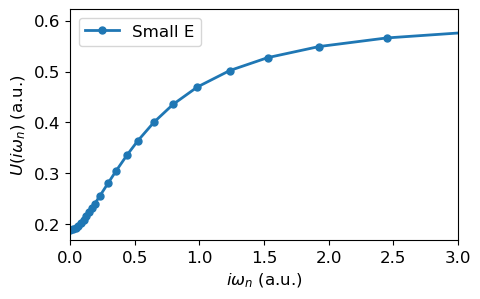

In [4]:
from coqui.utils.imag_axes_ft import IAFT

ir_kernel = IAFT(beta=300, wmax=3.0, prec="medium")
Uloc_iw = ir_kernel.tau_to_w_phsym(Uloc_t, stats='b')

iw_mesh = ir_kernel.wn_mesh(stats='b', positive_only=True) * np.pi / 300.0

fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(iw_mesh, (Vloc[0,0,0,0]+Uloc_iw[:,0,0,0,0]).real, 
        linewidth=2, marker='o', markersize=5, label='Small E')
ax.set_xlim(0,3)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('$i\omega_{n}$ (a.u.)', fontsize=12)
ax.set_ylabel('$U(i\omega_{n})$ (a.u.)', fontsize=12)
ax.legend(fontsize=12)
plt.show()

### 🖐️ Hands-on 3: Extracting the Hubbard–Kanamori Parameters

The local interaction returned by `downfold_local_coulomb` is a **four-index tensor** $U_{abcd}(i\Omega_n)$ in the MLWF basis. For many applications (e.g. DMFT), this tensor is reduced to the **Hubbard–Kanamori** parameters: intra-orbital $U$, inter-orbital $U'$, and Hund’s exchange $J$ (spin-flip / pair-hopping).

🪜 **Your task**
1. **Form the static tensor.**  
   Construct the static interactions tensor $U_{abcd}$ from the bare interaction $V$ and screened interaction $W(i\Omega_{n})$ at $\Omega_n=0$.  
2. **Extract $U$, $U'$, $J$ from $U_{abcd}(i\Omega_{n}=0)$:** 
   $$
   U \;=\; \langle U_{iiii}(0)\rangle_i,\qquad
   U' \;=\; \langle U_{iijj}(0)\rangle_{i\neq j},\qquad
   J_{\text{spin-flip}} \;=\; \langle U_{ijji}(0)\rangle_{i\neq j},\qquad
   J_{\text{pair-hopping}} \;=\; \langle U_{ijij}(0)\rangle_{i\neq j}.
   $$
3. **Check rotational-invariance identities.**  
   In a (near) rotationally invariant setting one expects
   $$
   U' \;\approx\; U - 2J,\qquad
   J_{\text{spin-flip}} \;=\; J_{\text{pair-hopping}} \;=\; J.
   $$
4. **Compare with the log summary and literature.**  
   Are your $U$, $U'$, $J$ consistent with the orbital-averaged values printed in CoQuí's log output? 

In [5]:
# Your task: Write a function to return orbital-average parametrization of the Hubbard Kanamori model
def orb_avg_coulomb(V_abcd):
    norb = V_abcd.shape[0]

    U = 0
    for i in range(norb):
        U += V_abcd[i,i,i,i]
    U /= norb

    Up = 0
    for i in range(norb):
        for j in range(i+1,norb):
            if i!=j:
                Up += V_abcd[i,i,j,j]
    Up /= (norb * (norb-1) ) / 2

    J_pair = 0
    for i in range(norb):
        for j in range(i+1,norb):
            if i!=j:
                J_pair += V_abcd[i,j,i,j]
    J_pair /= (norb * (norb-1) ) / 2

    J_spin = 0
    for i in range(norb):
        for j in range(i+1,norb):
            if i!=j:
                J_spin += V_abcd[i,j,j,i]
    J_spin /= (norb * (norb-1) ) / 2

    return U, Up, J_pair, J_spin

In [6]:
V, Vp, J_pair, J_spin = orb_avg_coulomb(Vloc.real * HARTREE_EV)
U, Up, J_pair_scr, J_spin_scr = orb_avg_coulomb(Uloc_iw[0].real * HARTREE_EV)
print("Small window")
print("-"*13)
print("Bare Interactions")
print(f"  - Intra-orbital: {V}")
print(f"  - Inter-orbital: {Vp}")
print(f"  - Pair hopping: {J_pair}")
print(f"  - Spin flip:    {J_spin}")
print("Screened Interactions")
print(f"  - Intra-orbital: {V+U}")
print(f"  - Inter-orbital: {Vp+Up}")
print(f"  - Pair hopping: {J_pair+J_pair_scr}")
print(f"  - Spin flip:    {J_spin+J_spin_scr}\n")

Small window
-------------
Bare Interactions
  - Intra-orbital: 16.381712253876987
  - Inter-orbital: 15.020604580083576
  - Pair hopping: 0.6468696787220632
  - Spin flip:    0.6468696787220632
Screened Interactions
  - Intra-orbital: 5.153100227556353
  - Inter-orbital: 4.025101885488343
  - Pair hopping: 0.5402556333785187
  - Spin flip:    0.5402556333785187



### 🖐️ Hands-on 4: Effect of the Energy Window in cRPA
In cRPA, the definition of the low-energy subspace depends on the **Wannier energy window** used to build the MLWF projectors. Enlarging this window includes more bands in the Wannierization, typically producing **more localized MLWFs**, which in turn **tends to increase** both the bare $V$ and the dynamic screened interaction $U(\tau)$.

🪜 **Your task**
1. Re-run the cRPA calculation with MLWFs generated using a **larger Wannier window** (a pre-generated archive is provided at `data/qe_inputs/svo/222/mlwf_dp/`).
   > 🔎 **Clarification:** In the updated MLWF archive, the Wannierization is performed over a **larger energy window**, but the downfolded subspace is still restricted to the three V $t_{2g}$ orbitals.  
   > This means the **dimension of the MLWF basis remains 3**, and you should continue to work with the \(3\times3\times3\times3\) block corresponding to the V $t_{2g}$ orbitals.
2. Extract the static Hubbard–Kanamori parameters $(U, U', J)$ from the output.
3. Compare these values with those from the smaller-window calculation.  
4. Discuss:
   - Do you observe the expected **increase** in the bare interactions?
   - What about the **frequency dependence**? Try to plot thier frequency dependences on the same plot.

> 💡 **Comment:** For MLWFs constructed from a **larger energy window**, the screened interaction $U(i\Omega_n)$ may show an **upturn near $\Omega_n=0$**.  
> This occurs because the $t_{2g}$ Wannier subspace no longer exactly spans only the three bands crossing the Fermi level, leaving a residual low-energy screening channel that makes the frequency dependence more sensitive around $\omega=0$.

In [7]:
# --- Phase 2: Simulation (cRPA) ---
crpa_params = {
    "screen_type": "crpa",
    "input_type": "mf",
    "prefix": "crpa",
    "wannier_file": "data/qe_inputs/svo/222/mlwf_dp/svo.mlwf.h5",
    "beta": 300,
    "wmax": 3.0,
    "iaft_prec": "medium"
}
Vloc2, Uloc2_t = coqui.downfold_local_coulomb(h_int=thc, params=crpa_params)
#Vloc2, Uloc2_t = Vloc_dp[:3, :3, :3, :3], Uloc_dp_t[:, :3, :3, :3, :3]
Uloc2_iw = ir_kernel.tau_to_w_phsym(Uloc2_t, stats='b')


╔══════════════════════════════════════════════════════════╗
║ [ WARNING ]                                              ║
║ Input type is set to "mf", while a CoQuí checkpoint      ║
║ HDF5 with the same prefix has been detected. CoQuí will  ║
║ overwrite the old checkpoint. Considering moving the old ║
║ HDF5 or changing CoQuí prefix next time.                 ║
╚══════════════════════════════════════════════════════════╝

  Projector Information
  ---------------------
  Number of impurities                      = 1
  Number of local orbitals per impurity     = 3
  Range of primary orbitals for local basis = [11, 30)

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 300.0 a.u.
  Frequency cutoff       = 3.3333333333333335 a.u.
  Lambda                 = 1000.0
  Precision              = 1e-10
  nt_f, nt_b, nw_f, nw_b = 52, 52, 52, 53


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐   ┌─┐  ┌┬┐┌─┐┬ ┬┌┐┌┌─┐┌─┐┬  ┌┬┐
║  ║ ║║═╬

In [8]:
V, Vp, J_pair, J_spin = orb_avg_coulomb(Vloc2.real * HARTREE_EV)
U, Up, J_pair_scr, J_spin_scr = orb_avg_coulomb(Uloc2_iw[0].real * HARTREE_EV)
print("Large window")
print("-"*13)
print("Bare Interactions")
print(f"  - Intra-orbital: {V}")
print(f"  - Inter-orbital: {Vp}")
print(f"  - Pair hopping: {J_pair}")
print(f"  - Spin flip:    {J_spin}")
print("Screened Interactions")
print(f"  - Intra-orbital: {V+U}")
print(f"  - Inter-orbital: {Vp+Up}")
print(f"  - Pair hopping: {J_pair+J_pair_scr}")
print(f"  - Spin flip:    {J_spin+J_spin_scr}")

Large window
-------------
Bare Interactions
  - Intra-orbital: 19.354531431373974
  - Inter-orbital: 17.682651441269368
  - Pair hopping: 0.8441709732982362
  - Spin flip:    0.8441709732982362
Screened Interactions
  - Intra-orbital: 16.847895992862085
  - Inter-orbital: 15.254018669202713
  - Pair hopping: 0.7694959620938875
  - Spin flip:    0.7694959620938875


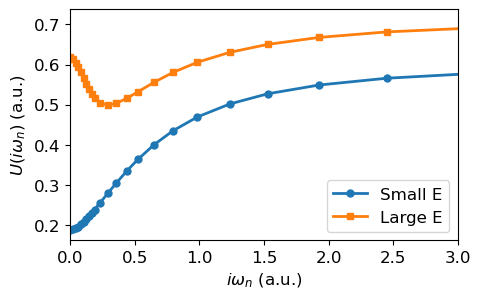

In [9]:
fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(iw_mesh, (Vloc[0,0,0,0]+Uloc_iw[:,0,0,0,0]).real, 
        linewidth=2, marker='o', markersize=5, label='Small E')
ax.plot(iw_mesh, (Vloc2[0,0,0,0]+Uloc2_iw[:,0,0,0,0]).real, 
        linewidth=2, marker='s', markersize=5, label='Large E')
ax.set_xlim(0,3)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('$i\omega_{n}$ (a.u.)', fontsize=12)
ax.set_ylabel('$U(i\omega_{n})$ (a.u.)', fontsize=12)
ax.legend(fontsize=12)
plt.show()